In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from ast import literal_eval
from sklearn.metrics import confusion_matrix
import itertools
import time

# <a id="code0">Decision Tree</a>

### Cross Validation modifying random_parameter at splitting the dataset

After some testing the input of a dataset with mean zero (gaussian distribution) has improved results. Same that SVM. Binomial target as (1,0) or (1,-1) does not affect results at all.

DTree accuracy improved with median Zero and target values (-1, 1)

In [2]:
df = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted_with_mean_True.csv')

In [3]:
df.loc[(df['Ranking'] <= 250), 'Top_250'] = 1
df.loc[(df['Ranking'] > 250), 'Top_250'] = -1
df.loc[(df['Ranking'] <= 500), 'Top_500'] = 1
df.loc[(df['Ranking'] > 500), 'Top_500'] = -1

Generating Feature set permutations

In [687]:
features = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum','Restaurant', 'Company', 'Liffey', 'Price Area']
feat_combo = []
for L in range(1, len(features)+1):
    for subset in itertools.combinations(features, L):
        feat_combo.append(subset)
print ('There are {} different combinations of feature set'.format(len(feat_combo)))

There are 2047 different combinations of feature set


In [1313]:
dtree_total_top_250 = pd.DataFrame(columns=['combo', 'accuracy', 'accuracy_train', 'max_depth', 
                                            'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])

In [1317]:
dtree_total_top_500 = pd.DataFrame(columns=['combo', 'accuracy', 'accuracy_train', 'max_depth', 
                                            'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])

In [1318]:
start = time.time()
# limiting the samples scope in order to have y-variance close to unit (defining 1,-1 binomial target) for a balanced model
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500
space = '     ' # to print on same line while calculating
dtree_combo = pd.DataFrame(columns=['combo', 'accuracy', 'accuracy_train', 'max_depth', 
                                    'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])
m=0
for m in range (4, 11, 2):
    j=0
    for j in range(0, 100, 3):
        i=0
        for i in range (0, len(feat_combo)):
            X = dff[list(feat_combo[i])].values 
            y = dff['Top_500'].values #Top_250/Top_500
            X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, 
                                                                random_state=j, stratify=dff['Top_500']) #Top_250/Top_500        
            dfTree = DecisionTreeClassifier(criterion="entropy", max_depth = m)
            dfTree.fit(X_train, y_train)
            yhat = dfTree.predict(X_test)
            yhat_train = dfTree.predict(X_train)

            dtree_combo.at[i, 'combo'] = list(feat_combo[i])
            dtree_combo.at[i, 'accuracy'] = metrics.accuracy_score(y_test, yhat)
            dtree_combo.at[i, 'accuracy_train'] = metrics.accuracy_score(y_train, yhat_train)
            dtree_combo.at[i, 'max_depth'] = m
            dtree_combo.at[i, 'f1_score'] = f1_score(y_test, yhat, average='weighted')
            dtree_combo.at[i, 'jaccard_score'] = jaccard_score(y_test, yhat, average='weighted')
            dtree_combo.at[i, 'random_state'] = j
            dtree_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))

            print( 'm:{}-random_state:{},{}{}'.format(m, j, dtree_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
        dtree_total_top_500 = dtree_total_top_500.append(dtree_combo) #Top_250/Top_500
print(round(time.time() - start, 3))

1692.498dom_state:99,['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Company', 'Liffey', 'Price Area']                                                  


Converting cell objects to float to work with

In [1366]:
for column in list(dtree_total_top_250.columns)[1:]:
    dtree_total_top_250[column] = dtree_total_top_250[column].astype('float')
for column in list(dtree_total_top_500.columns)[1:]:
    dtree_total_top_500[column] = dtree_total_top_500[column].astype('float')

In [1417]:
dtree_total_top_250.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,accuracy_train,max_depth,f1_score,jaccard_score,random_state,nFeatures
180,"[Cafe, Pub, Price Area]",0.722892,0.650456,8.0,0.711495,0.555895,12.0,3.0
1835,"[Hotel, Tourism, University, Cafe, Luas, Museu...",0.722892,0.702128,6.0,0.722892,0.566038,84.0,8.0


In [1416]:
dtree_total_top_500.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,accuracy_train,max_depth,f1_score,jaccard_score,random_state,nFeatures
613,"[Hotel, Tourism, Pub, Luas, Liffey]",0.699387,0.766975,8.0,0.699341,0.537732,24.0,5.0
1135,"[Hotel, Tourism, Luas, Museum, Restaurant, Lif...",0.693252,0.649691,4.0,0.686749,0.524987,39.0,6.0


In [1319]:
#dtree_total_top_500.to_csv('CSVs/dtree_total_top_500.csv', index=False)

Let's visualize how the paremeter max_depth affects the accuracy

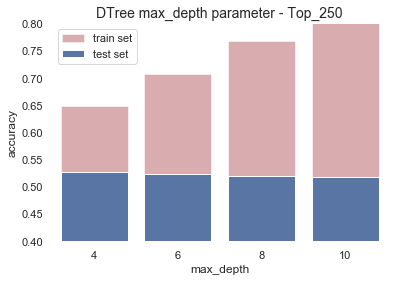

In [1400]:
max_d = dtree_total_top_250.groupby(by=['max_depth']).mean()
max_d.index = max_d.index.astype('int')
sns.set(style='white')
sns.barplot(x=max_d.index, y='accuracy_train', data=max_d, label='train set', color='r', alpha=0.5)
sns.barplot(x=max_d.index, y='accuracy', data=max_d, label='test set', color='b', alpha=1)
sns.despine(left=True, top=True, bottom=True, right=True)
plt.ylim(0.4, 0.8)
plt.legend()
plt.xlabel('max_depth')
plt.title('DTree max_depth parameter - Top_250', fontsize=14)
plt.savefig('charts/DTree_max_depth_Top_250.png', bbox_inches='tight', format='png', dpi=500)

depth_max set the maximum splits a tree can make before giving a prediction. In this case, with many repetitions of this process we have forced it to an extremely classification tree with many nodes overfitting the training set. Therefore, we are using just the data with 4 depths.

In [1403]:
dtree_total_top_250_4 = dtree_total_top_250.loc[dtree_total_top_250['max_depth'] == 4].copy()
dtree_total_top_500_4 = dtree_total_top_500.loc[dtree_total_top_500['max_depth'] == 4].copy()

In [1414]:
print('Test accuracy mean Top_250: {} %'.format(round(100*dtree_total_top_250_4.accuracy.mean(), 2)))
print('Train accuracy mean Top_250: {} %'.format(round(100*dtree_total_top_250_4.accuracy_train.mean(), 2)))
print('Test accuracy mean Top_500: {} %'.format(round(100*dtree_total_top_500_4.accuracy.mean(), 2)))
print('Train accuracy mean Top_500: {} %'.format(round(100*dtree_total_top_500_4.accuracy_train.mean(), 2)))

Test accuracy mean Top_250: 52.76 %
Train accuracy mean Top_250: 64.91 %
Test accuracy mean Top_500: 54.4 %
Train accuracy mean Top_500: 62.68 %


These results are for all combinations, not for the optimal feature set, which will be calculated using KFold & cross_validation

Maximum, minimum & average mean for each random state

In [1419]:
dtree_acc_max_250 = dtree_total_top_250_4.groupby(by=['random_state'])['accuracy'].max()
dtree_acc_mean_250 = dtree_total_top_250_4.groupby(by=['random_state'])['accuracy'].mean()
dtree_acc_min_250 = dtree_total_top_250_4.groupby(by=['random_state'])['accuracy'].min()

dtree_acc_max_500 = dtree_total_top_500_4.groupby(by=['random_state'])['accuracy'].max()
dtree_acc_mean_500 = dtree_total_top_500_4.groupby(by=['random_state'])['accuracy'].mean()
dtree_acc_min_500 = dtree_total_top_500_4.groupby(by=['random_state'])['accuracy'].min()

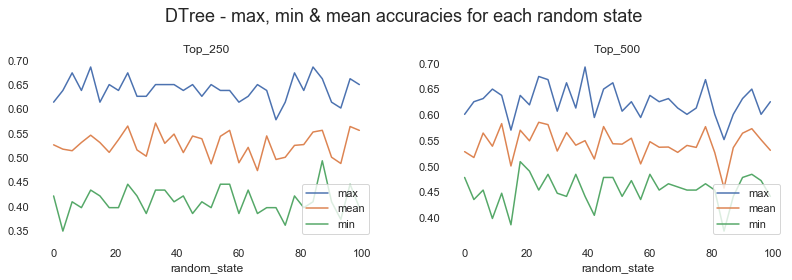

In [1422]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=3.5)
fig.suptitle('DTree - max, min & mean accuracies for each random state', y=1.02, fontsize=18)

g1 = sns.lineplot(x=dtree_acc_max_250.index, y=dtree_acc_max_250.values, label='max', ax=ax[0])
sns.lineplot(x=dtree_acc_mean_250.index, y=dtree_acc_mean_250.values, label='mean',ax=ax[0])
sns.lineplot(x=dtree_acc_min_250.index, y=dtree_acc_min_250.values, label='min',ax=ax[0])
g1.set(title='Top_250')

g2 = sns.lineplot(x=dtree_acc_max_500.index, y=dtree_acc_max_500.values, label='max',ax=ax[1])
sns.lineplot(x=dtree_acc_mean_500.index, y=dtree_acc_mean_500.values, label='mean',ax=ax[1])
sns.lineplot(x=dtree_acc_min_500.index, y=dtree_acc_min_500.values, label='min',ax=ax[1])
g2.set(title='Top_500')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_accuracies_random_state.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code1">DTree Cross Validation using K-Fold and cross_val_score</a>

### Top_250

In [1424]:
DTree_KF_CV_250 = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures'])

In [1430]:
DTree_KF_CV_500 = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures'])

In [1431]:
start = time.time()
# limiting the samples scope in order to have y-variance close to unit (defining 1,-1 binomial target) for a balanced model
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500
space = '     ' # to print on same line while calculating
# iterated dataframe
dtree_combo = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures'])
i=0
for i in range (0, len(feat_combo)):
    # adding features and target                       
    X = dff[list(feat_combo[i])].values 
    y = dff['Top_500'].values #Top_250/Top_500
    # setting the classifier
    clf = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    
    # KFold
    scores = []
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    # cross_val_score
    cv_scores = cross_val_score(clf, X, y, cv=10)
    
    # adding to iterated dataframe
    dtree_combo.at[i, 'combo'] = 'fixing bug passing a list into a cell not being an object'
    dtree_combo.at[i, 'combo'] = list(feat_combo[i])
    dtree_combo.at[i, 'KF_acc_mean'] = np.mean(scores)
    dtree_combo.at[i, 'KF_acc_max'] = np.max(scores)
    dtree_combo.at[i, 'KF_acc_min'] = np.min(scores)
    dtree_combo.at[i, 'KF_var'] = np.var(scores)
    dtree_combo.at[i, 'CV_acc_mean'] = cv_scores.mean()
    dtree_combo.at[i, 'CV_acc_max'] = cv_scores.max()
    dtree_combo.at[i, 'CV_acc_min'] = cv_scores.min()
    dtree_combo.at[i, 'CV_var'] = cv_scores.var()
    dtree_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))


    print( '{}{}'.format(dtree_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
# adding each row from the iterated dataframe to the final dataframe
DTree_KF_CV_500 = DTree_KF_CV_500.append(dtree_combo)
print(round(time.time() - start, 3))

82.933l', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Company', 'Liffey', 'Price Area']                                                  


In [1428]:
DTree_KF_CV_250.sort_values(by=['KF_acc_max'], ascending=False).head(2)

,combo,KF_acc_mean,KF_acc_max,KF_acc_min,KF_var,CV_acc_mean,CV_acc_max,CV_acc_min,CV_var,nFeatures
657,"[Hotel, University, Cafe, Museum, Company]",0.542451,0.95122,0.219512,0.0857699,0.526481,0.642857,0.439024,0.00312423,5
1035,"[Hotel, Tourism, University, Cafe, Museum, Com...",0.535075,0.95122,0.146341,0.0917929,0.50482,0.609756,0.390244,0.00336481,6


In [1432]:
DTree_KF_CV_500.sort_values(by=['KF_acc_max'], ascending=False).head(2)

,combo,KF_acc_mean,KF_acc_max,KF_acc_min,KF_var,CV_acc_mean,CV_acc_max,CV_acc_min,CV_var,nFeatures
1390,"[Tourism, Pub, Museum, Restaurant, Company, Li...",0.458913,0.814815,0.271605,0.0272769,0.553689,0.654321,0.506173,0.0027756,6
1483,"[Pub, Museum, Restaurant, Company, Liffey, Pri...",0.434222,0.814815,0.271605,0.021529,0.549985,0.654321,0.481481,0.00291571,6


In [1433]:
DTree_KF_CV_250.to_csv('CSVs/DTree_KF_CV_250.csv', index=False)
DTree_KF_CV_500.to_csv('CSVs/DTree_KF_CV_500.csv', index=False)

Converting columns object to float to work with

In [1435]:
for column in list(DTree_KF_CV_250.columns)[1:]:
    DTree_KF_CV_250[column] = DTree_KF_CV_250[column].astype('float')
for column in list(DTree_KF_CV_500.columns)[1:]:
    DTree_KF_CV_500[column] = DTree_KF_CV_500[column].astype('float')

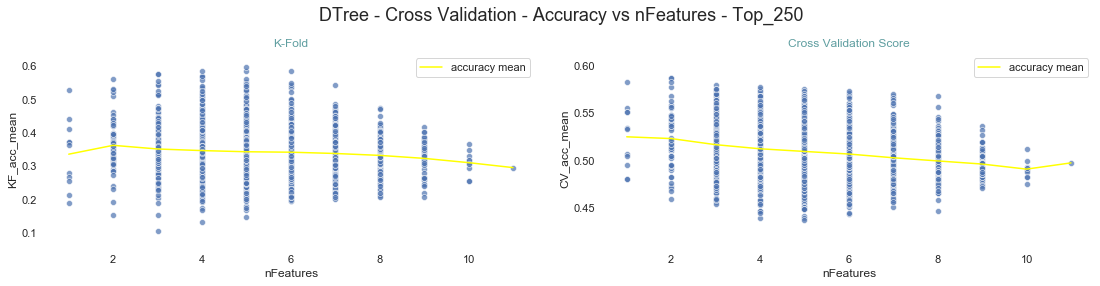

In [1436]:
figures = [0, 1]
axis_x = 'nFeatures'
axis_y = ['KF_acc_mean', 'CV_acc_mean']
titles_figs =['K-Fold', 'Cross Validation Score']
data = DTree_KF_CV_250
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
fig.tight_layout(pad=3.0)
fig.suptitle('DTree - Cross Validation - Accuracy vs nFeatures - Top_250', y=1.02, fontsize=18)

for ax_y, titl, figs in zip(axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.7).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_Cross_Val_combo_nfeatures.png', bbox_inches='tight', format='png', dpi=500)

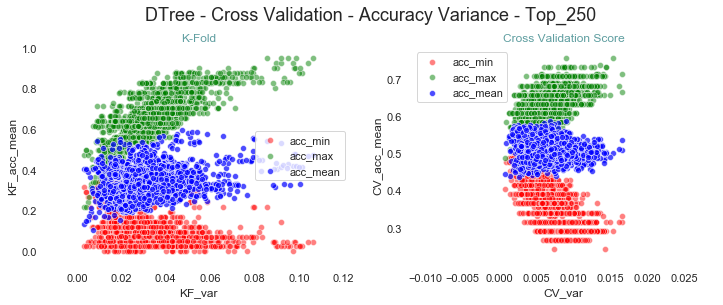

In [1438]:
figures = [0, 1]
axis_x = ['KF_var', 'CV_var']
axis_y_min = ['KF_acc_min', 'CV_acc_min']
axis_y_mean = ['KF_acc_mean', 'CV_acc_mean']
axis_y_max = ['KF_acc_max', 'CV_acc_max']
titles_figs =['K-Fold', 'Cross Validation Score']
data = DTree_KF_CV_250
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
fig.suptitle('DTree - Cross Validation - Accuracy Variance - Top_250', y=1.02, fontsize=18)
for ax_yi, ax_yea, ax_ya, ax_x, titl, figs in zip(axis_y_min, axis_y_mean, 
                                                  axis_y_max, axis_x, titles_figs, figures):
    sns.scatterplot(x=ax_x, y=ax_yi, data=data, alpha=0.5, 
                    label='acc_min', color='red', ax=axs[figs]).set_title(titl, color='cadetblue')
    sns.scatterplot(x=ax_x, y=ax_ya, data=data, alpha=0.5, 
                    label='acc_max', color='green', ax=axs[figs])
    sns.scatterplot(x=ax_x, y=ax_yea, data=data, alpha=0.7, 
                    label='acc_mean', color='blue', ax=axs[figs])
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_Cross_Val_Accuracy_Variance.png', bbox_inches='tight', format='png', dpi=500)

First thing we notice is that the highest accuracy values have also the highest variance (max & min accuracies within a feature set more dispersed)

Saving the dataframe for convenience

In [1550]:
dfc = DTree_KF_CV_250.copy()

Now we can apply the same methodology that with SVM classifier. First at all, let's define some initial conditions in order to find the best combos (feature set):

* K-Fold < 0.03 variance & > 0.5 accuracy
* CV < 0.007 variance & > 0.6 accuracy
* combo always above mean() for same nFeature

In [1474]:
print('KFold: {}'.format(dfc.loc[(dfc['KF_var'] < 0.03) 
                        & (dfc['KF_acc_max'] > 0.5), 'nFeatures'].count()))
print('CV: {}'.format(dfc.loc[(dfc['CV_var'] < 0.007) 
                        & (dfc['CV_acc_max'] > 0.6), 'nFeatures'].count()))

KFold: 733
CV: 798


In [1551]:
KFold_1 = dfc.loc[(dfc['KF_var'] < 0.03) & (dfc['KF_acc_max'] > 0.5)].copy()
CV_1 = dfc.loc[(dfc['CV_var'] < 0.007) & (dfc['CV_acc_max'] > 0.6)].copy()
KFold_1.reset_index(drop=True, inplace=True)
CV_1.reset_index(drop=True, inplace=True)

We need the accuracy values of samples grouped by nFeatures (yellow accuracy mean on the chart)

In [1552]:
KFold_n_max = dfc.groupby(by=['nFeatures']).mean()['KF_acc_max'].values
KFold_n_mean = dfc.groupby(by=['nFeatures']).mean()['KF_acc_mean'].values
KFold_n_min = dfc.groupby(by=['nFeatures']).mean()['KF_acc_min'].values

CV_n_max = dfc.groupby(by=['nFeatures']).mean()['CV_acc_max'].values
CV_n_mean = dfc.groupby(by=['nFeatures']).mean()['CV_acc_mean'].values
CV_n_min = dfc.groupby(by=['nFeatures']).mean()['CV_acc_min'].values

applying the third condition:

* combo always above mean() for same nFeature

In [1553]:
KFold_2 = pd.DataFrame()
CV_2 = pd.DataFrame()
i=0
for i in range (0, len(KFold_1)):
    if (KFold_1.at[i, 'KF_acc_mean'] > KFold_n_mean[int(KFold_1.at[i, 'nFeatures'])-1]):
        if (KFold_1.at[i, 'KF_acc_min'] > KFold_n_min[int(KFold_1.at[i, 'nFeatures'])-1]):
            if (KFold_1.at[i, 'KF_acc_max'] > KFold_n_max[int(KFold_1.at[i, 'nFeatures'])-1]):
                KFold_2 = KFold_2.append(KFold_1.iloc[i,:])
i=0
for i in range (0, len(CV_1)):
    if (CV_1.at[i, 'CV_acc_mean'] > CV_n_mean[int(CV_1.at[i, 'nFeatures'])-1]):
        if (CV_1.at[i, 'CV_acc_min'] > CV_n_min[int(CV_1.at[i, 'nFeatures'])-1]):
            if (CV_1.at[i, 'CV_acc_max'] > CV_n_max[int(CV_1.at[i, 'nFeatures'])-1]):
                CV_2 = CV_2.append(CV_1.iloc[i,:])

In [1554]:
print('KFold group has been reduced from {} to {} samples'.format(KFold_1.shape[0], KFold_2.shape[0]))
print('CV group has been reduced from {} to {} samples'.format(CV_1.shape[0], CV_2.shape[0]))

KFold group has been reduced from 733 to 100 samples
CV group has been reduced from 798 to 315 samples


We compare KFold & CV groups to get matches

In [1555]:
match_list = []
for KF in KFold_2.combo:
    for CV in CV_2.combo:
        if KF==CV:
            match_list.append(KF)
print('We got {} matches'.format(len(match_list)))

We got 28 matches


In [1556]:
KFold_2.reset_index(drop=True, inplace=True)
dtree_match_250 = pd.DataFrame()
for combo in match_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            dtree_match_250 = dtree_match_250.append(KFold_2.iloc[i,:])

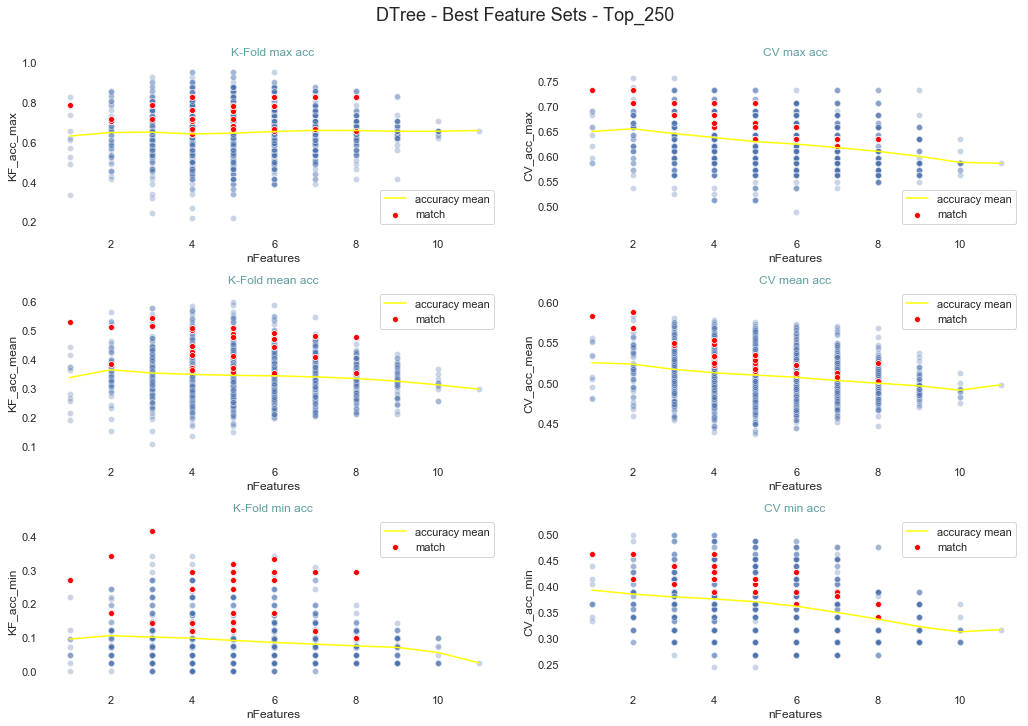

In [1480]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
axis_x = 'nFeatures'
axis_y = ['KF_acc_max', 'CV_acc_max', 'KF_acc_mean', 'CV_acc_mean', 'KF_acc_min', 'CV_acc_min']
titles_figs =['K-Fold max acc', 'CV max acc', 'K-Fold mean acc', 'CV mean acc', 'K-Fold min acc', 'CV min acc']
data = dfc
data_match = dtree_match_250
data_dfs = [KFold_2, CV_2, KFold_2, CV_2, KFold_2, CV_2]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
fig.suptitle('DTree - Best Feature Sets - Top_250', y=1.02, fontsize=18)

for ax_y, titl, data_df, figs in zip(axis_y, titles_figs, data_dfs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.3).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=1, label='potential match', color='red')
    sns.scatterplot(x=axis_x, y=ax_y, data=data_match, ax=axs[figs], alpha=1, label='match', color='red')
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_match, ax=axs[figs], alpha=1, label='top feature set', color='black', marker='D')
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_Best_Feature_Sets_Top_250.png', bbox_inches='tight', format='png', dpi=500)

We have 28 different feature set for our model. We can narrow the group, so let's get the Top 10 Feature Sets.

* we just start increasing the accuracy mean (yellow line) until we get 10 items in the match_list

In [1557]:
dtree_top10_temp = dtree_match_250.copy()
KFold_2.reset_index(drop=True, inplace=True)
CV_2.reset_index(drop=True, inplace=True)
deltas = np.arange(1.01, 1.10, 0.01)

for delta in deltas: # we increase the accuracy mean 1% each iteration
    if len(dtree_top10_temp) > 10:
        dtree_top10_temp = []
        KFold_3 = pd.DataFrame()
        CV_3 = pd.DataFrame()
        i=0
        for i in range (0, len(KFold_2)):
            if (KFold_2.at[i, 'KF_acc_mean'] > (delta * (KFold_n_mean[int(KFold_2.at[i, 'nFeatures'])-1]))):
                if (KFold_2.at[i, 'KF_acc_min'] > (delta * (KFold_n_min[int(KFold_2.at[i, 'nFeatures'])-1]))):
                    if (KFold_2.at[i, 'KF_acc_max'] > (delta * (KFold_n_max[int(KFold_2.at[i, 'nFeatures'])-1]))):
                        KFold_3 = KFold_3.append(KFold_2.iloc[i,:])
        i=0
        for i in range (0, len(CV_2)):
            if (CV_2.at[i, 'CV_acc_mean'] > (delta * (CV_n_mean[int(CV_2.at[i, 'nFeatures'])-1]))):
                if (CV_2.at[i, 'CV_acc_min'] > (delta * (CV_n_min[int(CV_2.at[i, 'nFeatures'])-1]))):
                    if (CV_2.at[i, 'CV_acc_max'] > (delta * (CV_n_max[int(CV_2.at[i, 'nFeatures'])-1]))):
                        CV_3 = CV_3.append(CV_2.iloc[i,:])
        try:
            for KF in KFold_3['combo']:
                for CV in CV_3['combo']:
                    if KF==CV:
                        dtree_top10_temp.append(KF)
            dtree_top10_list = dtree_top10_temp.copy()
        except:
            print('There are {} best combos with delta {}'.format(len(dtree_top10_list), delta))
            break
    else:
        print('There are {} best combos with delta {}'.format(len(dtree_top10_list), delta))
        break

There are 7 best combos with delta 1.05


In [1558]:
dtree_top10_list

[['Hotel'],
 ['Hotel', 'Museum'],
 ['Hotel', 'Company'],
 ['Hotel', 'Tourism', 'Price Area'],
 ['Hotel', 'Company', 'Price Area'],
 ['Hotel', 'University', 'Company', 'Price Area'],
 ['Hotel', 'Tourism', 'University', 'Company', 'Price Area']]

In [1559]:
dtree_top_feats_250 = pd.DataFrame()
for combo in dtree_top10_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            dtree_top_feats_250 = dtree_top_feats_250.append(KFold_2.iloc[i,:])
DTree_CV_top_feats_Top_250 = dtree_top_feats_250.copy()
DTree_CV_top_feats_Top_250.to_csv('CSVs/DTree_CV_top_feats_Top_250.csv', index=False)

In [1560]:
DTree_CV_top_feats_Top_250

,CV_acc_max,CV_acc_mean,CV_acc_min,CV_var,KF_acc_max,KF_acc_mean,KF_acc_min,KF_var,combo,nFeatures
0,0.731707,0.582346,0.463415,0.006048,0.785714,0.528397,0.268293,0.020955,[Hotel],1.0
2,0.731707,0.587166,0.414634,0.006806,0.707317,0.383391,0.170732,0.027815,"[Hotel, Museum]",2.0
3,0.707317,0.567944,0.463415,0.006755,0.714286,0.509233,0.341463,0.011526,"[Hotel, Company]",2.0
7,0.682927,0.546283,0.404762,0.006964,0.785714,0.514808,0.142857,0.029979,"[Hotel, Tourism, Price Area]",3.0
11,0.707317,0.548606,0.439024,0.005524,0.714286,0.543148,0.414634,0.009110,"[Hotel, Company, Price Area]",3.0
22,0.707317,0.548548,0.463415,0.005570,0.714286,0.501626,0.243902,0.015763,"[Hotel, University, Company, Price Area]",4.0
42,0.707317,0.533856,0.414634,0.006848,0.714286,0.486992,0.243902,0.024281,"[Hotel, Tourism, University, Company, Price Area]",5.0


In [1514]:
DTree_CV_top_feats_Top_250.to_csv('CSVs/DTree_CV_top_feats_Top_250.csv', index = False)

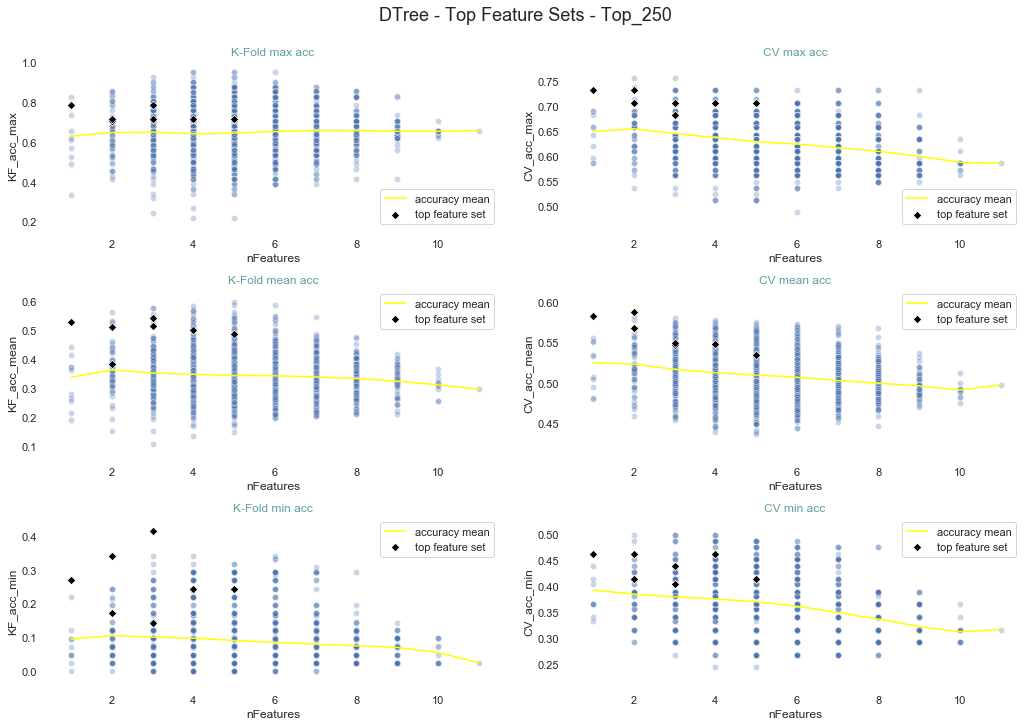

In [1561]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
axis_x = 'nFeatures'
axis_y = ['KF_acc_max', 'CV_acc_max', 'KF_acc_mean', 'CV_acc_mean', 'KF_acc_min', 'CV_acc_min']
titles_figs =['K-Fold max acc', 'CV max acc', 'K-Fold mean acc', 'CV mean acc', 'K-Fold min acc', 'CV min acc']
data = dfc
data_match = DTree_CV_top_feats_Top_250
data_dfs = [KFold_2, CV_2, KFold_2, CV_2, KFold_2, CV_2]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
fig.suptitle('DTree - Top Feature Sets - Top_250', y=1.02, fontsize=18)

for ax_y, titl, data_df, figs in zip(axis_y, titles_figs, data_dfs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.3).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=1, label='potential match', color='red')
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_match, ax=axs[figs], alpha=1, label='match', color='red')
    sns.scatterplot(x=axis_x, y=ax_y, data=data_match, ax=axs[figs], alpha=1, label='top feature set', color='black', marker='D')
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_Top_Feature_Sets_Top_250.png', bbox_inches='tight', format='png', dpi=500)

In [1488]:
print('DTree Top_250 K-Folds accuracy: {} %'.format(round(100*DTree_CV_top_feats_Top_250.KF_acc_mean.mean(), 2)))
print('DTree Top_250 Cross Validation accuracy: {} %'.format(round(100*DTree_CV_top_feats_Top_250.CV_acc_mean.mean(), 2)))

DTree Top_250 K-Folds accuracy: 49.54 %
DTree Top_250 Cross Validation accuracy: 55.93 %


Top feature set for Top_250 are between 1 and 5 features

In [1502]:
feature_top = {'Hotel':0, 'Tourism':0, 'University':0, 'Cafe':0, 'Pub':0, 
               'Luas':0, 'Museum':0,'Restaurant':0, 'Company':0, 'Liffey':0, 'Price Area':0}
for feat in feature_top.keys():
    for combo in dtree_top10_list:
        feature_top[feat] += combo.count(feat)
print(feature_top)

{'Hotel': 7, 'Tourism': 2, 'University': 2, 'Cafe': 0, 'Pub': 0, 'Luas': 0, 'Museum': 1, 'Restaurant': 0, 'Company': 4, 'Liffey': 0, 'Price Area': 4}


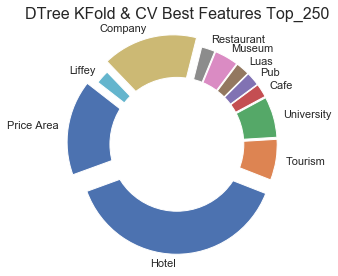

In [1503]:
for feat in feature_top.keys(): # there are several null values.
    feature_top[feat] += 1      # this is just for a better visualization
    feature_top[feat] = feature_top[feat]**2
    feature_top[feat] += 3
    
labels = feature_top.keys()
sizes = feature_top.values()
explode = (0.15,0.05,0.05,0.05, 0.05,0.05,0.05,0.05,0.15,0.05,0.15)
plt.pie(sizes, labels=labels,  startangle=200, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('DTree KFold & CV Best Features Top_250', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/DTree_KFold_CV_Best_Features_Top_250.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### DTree K-Fold & Cross Validation Score Top_500

(following the same methodology that with Top_250)

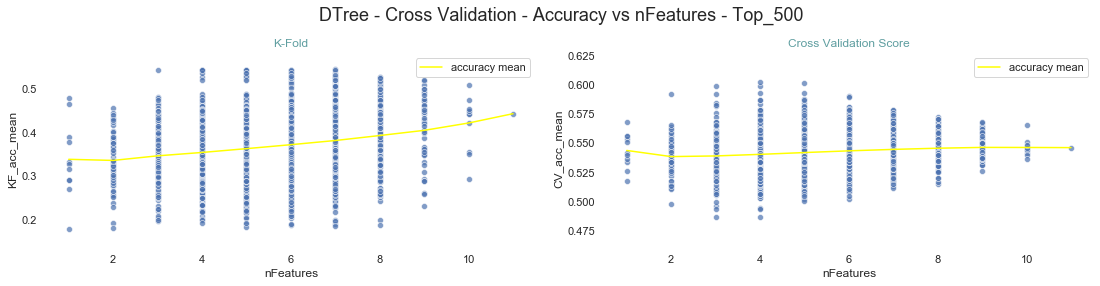

In [1504]:
figures = [0, 1]
axis_x = 'nFeatures'
axis_y = ['KF_acc_mean', 'CV_acc_mean']
titles_figs =['K-Fold', 'Cross Validation Score']
data = DTree_KF_CV_500
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
fig.tight_layout(pad=3.0)
fig.suptitle('DTree - Cross Validation - Accuracy vs nFeatures - Top_500', y=1.02, fontsize=18)

for ax_y, titl, figs in zip(axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.7).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_Cross_Val_combo_nfeatures_Top_500.png', bbox_inches='tight', format='png', dpi=500)

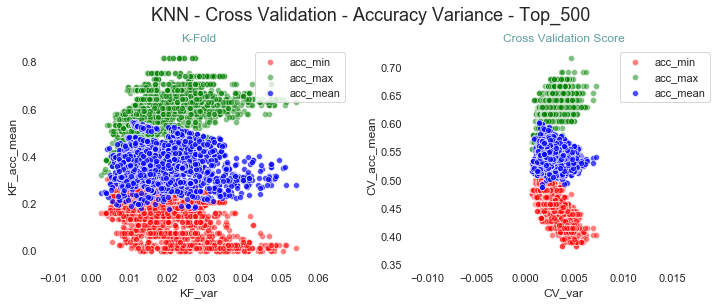

In [1505]:
figures = [0, 1]
axis_x = ['KF_var', 'CV_var']
axis_y_min = ['KF_acc_min', 'CV_acc_min']
axis_y_mean = ['KF_acc_mean', 'CV_acc_mean']
axis_y_max = ['KF_acc_max', 'CV_acc_max']
titles_figs =['K-Fold', 'Cross Validation Score']
data = DTree_KF_CV_500
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
fig.suptitle('KNN - Cross Validation - Accuracy Variance - Top_500', y=1.02, fontsize=18)
for ax_yi, ax_yea, ax_ya, ax_x, titl, figs in zip(axis_y_min, axis_y_mean, 
                                                  axis_y_max, axis_x, titles_figs, figures):
    sns.scatterplot(x=ax_x, y=ax_yi, data=data, alpha=0.5, 
                    label='acc_min', color='red', ax=axs[figs]).set_title(titl, color='cadetblue')
    sns.scatterplot(x=ax_x, y=ax_ya, data=data, alpha=0.5, 
                    label='acc_max', color='green', ax=axs[figs])
    sns.scatterplot(x=ax_x, y=ax_yea, data=data, alpha=0.7, 
                    label='acc_mean', color='blue', ax=axs[figs])
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_Cross_Val_Accuracy_Variance_Top_500.png', bbox_inches='tight', format='png', dpi=500)

Same code that earlier with different initial values (we pick them just having a look on the chart. We don't have to be accurate on this, due to we'll filter the results later till we get the optimal feature set for out model using the DTree classifier and Cross Validation in this case

In [1507]:
dfc = DTree_KF_CV_500.copy()

KFold_1 = dfc.loc[(dfc['KF_var'] < 0.02) & (dfc['KF_acc_max'] > 0.5)].copy()
CV_1 = dfc.loc[(dfc['CV_var'] < 0.005) & (dfc['CV_acc_max'] > 0.6)].copy()
KFold_1.reset_index(drop=True, inplace=True)
CV_1.reset_index(drop=True, inplace=True)

KFold_n_max = dfc.groupby(by=['nFeatures']).mean()['KF_acc_max'].values
KFold_n_mean = dfc.groupby(by=['nFeatures']).mean()['KF_acc_mean'].values
KFold_n_min = dfc.groupby(by=['nFeatures']).mean()['KF_acc_min'].values

CV_n_max = dfc.groupby(by=['nFeatures']).mean()['CV_acc_max'].values
CV_n_mean = dfc.groupby(by=['nFeatures']).mean()['CV_acc_mean'].values
CV_n_min = dfc.groupby(by=['nFeatures']).mean()['CV_acc_min'].values

KFold_2 = pd.DataFrame()
CV_2 = pd.DataFrame()
i=0
for i in range (0, len(KFold_1)):
    if (KFold_1.at[i, 'KF_acc_mean'] > KFold_n_mean[int(KFold_1.at[i, 'nFeatures'])-1]):
        if (KFold_1.at[i, 'KF_acc_min'] > KFold_n_min[int(KFold_1.at[i, 'nFeatures'])-1]):
            if (KFold_1.at[i, 'KF_acc_max'] > KFold_n_max[int(KFold_1.at[i, 'nFeatures'])-1]):
                KFold_2 = KFold_2.append(KFold_1.iloc[i,:])
i=0
for i in range (0, len(CV_1)):
    if (CV_1.at[i, 'CV_acc_mean'] > CV_n_mean[int(CV_1.at[i, 'nFeatures'])-1]):
        if (CV_1.at[i, 'CV_acc_min'] > CV_n_min[int(CV_1.at[i, 'nFeatures'])-1]):
            if (CV_1.at[i, 'CV_acc_max'] > CV_n_max[int(CV_1.at[i, 'nFeatures'])-1]):
                CV_2 = CV_2.append(CV_1.iloc[i,:])
                
print('KFold group has been reduced from {} to {} samples'.format(KFold_1.shape[0], KFold_2.shape[0]))
print('CV group has been reduced from {} to {} samples'.format(CV_1.shape[0], CV_2.shape[0]))

KFold group has been reduced from 885 to 346 samples
CV group has been reduced from 1815 to 448 samples


In [1508]:
match_list = []
for KF in KFold_2.combo:
    for CV in CV_2.combo:
        if KF==CV:
            match_list.append(KF)
print('We got {} matches'.format(len(match_list)))

We got 116 matches


In [1515]:
dtree_top10_temp = match_list.copy()
KFold_2.reset_index(drop=True, inplace=True)
CV_2.reset_index(drop=True, inplace=True)
deltas = np.arange(1.01, 1.10, 0.01)

for delta in deltas: # we increase the accuracy mean 1% each iteration
    if len(dtree_top10_temp) > 10:
        dtree_top10_temp = []
        KFold_3 = pd.DataFrame()
        CV_3 = pd.DataFrame()
        i=0
        for i in range (0, len(KFold_2)):
            if (KFold_2.at[i, 'KF_acc_mean'] > (delta * (KFold_n_mean[int(KFold_2.at[i, 'nFeatures'])-1]))):
                if (KFold_2.at[i, 'KF_acc_min'] > (delta * (KFold_n_min[int(KFold_2.at[i, 'nFeatures'])-1]))):
                    if (KFold_2.at[i, 'KF_acc_max'] > (delta * (KFold_n_max[int(KFold_2.at[i, 'nFeatures'])-1]))):
                        KFold_3 = KFold_3.append(KFold_2.iloc[i,:])
        i=0
        for i in range (0, len(CV_2)):
            if (CV_2.at[i, 'CV_acc_mean'] > (delta * (CV_n_mean[int(CV_2.at[i, 'nFeatures'])-1]))):
                if (CV_2.at[i, 'CV_acc_min'] > (delta * (CV_n_min[int(CV_2.at[i, 'nFeatures'])-1]))):
                    if (CV_2.at[i, 'CV_acc_max'] > (delta * (CV_n_max[int(CV_2.at[i, 'nFeatures'])-1]))):
                        CV_3 = CV_3.append(CV_2.iloc[i,:])
        try:
            for KF in KFold_3['combo']:
                for CV in CV_3['combo']:
                    if KF==CV:
                        dtree_top10_temp.append(KF)
            DTree_top10_list_500 = dtree_top10_temp.copy()
        except:
            print('There are {} best combos with delta {}'.format(len(DTree_top10_list_500), delta))
            break
    else:
        print('There are {} best combos with delta {}'.format(len(DTree_top10_list_500), delta))
        break

There are 9 best combos with delta 1.06


In [1516]:
DTree_top_feats_500 = pd.DataFrame()
for combo in DTree_top10_list_500:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            DTree_top_feats_500 = DTree_top_feats_500.append(KFold_2.iloc[i,:])

In [1517]:
DTree_top_feats_500

,CV_acc_max,CV_acc_mean,CV_acc_min,CV_var,KF_acc_max,KF_acc_mean,KF_acc_min,KF_var,combo,nFeatures
57,0.679012,0.577085,0.506173,0.002603,0.654321,0.421816,0.172840,0.019363,"[Hotel, Cafe, Museum, Liffey]",4.0
69,0.679012,0.572162,0.481481,0.002777,0.617284,0.446582,0.268293,0.010994,"[Hotel, Museum, Restaurant, Liffey]",4.0
70,0.679012,0.583273,0.506173,0.002605,0.691358,0.460148,0.280488,0.014665,"[Hotel, Museum, Company, Liffey]",4.0
144,0.666667,0.570927,0.481481,0.002283,0.617284,0.451521,0.268293,0.011832,"[Hotel, University, Museum, Restaurant, Liffey]",5.0
145,0.666667,0.578335,0.506173,0.002366,0.691358,0.456444,0.280488,0.015210,"[Hotel, University, Museum, Company, Liffey]",5.0
154,0.679012,0.577085,0.506173,0.002603,0.654321,0.421816,0.172840,0.019363,"[Hotel, Cafe, Museum, Liffey, Price Area]",5.0
166,0.679012,0.572162,0.481481,0.002777,0.617284,0.447817,0.268293,0.011246,"[Hotel, Museum, Restaurant, Liffey, Price Area]",5.0
167,0.679012,0.584508,0.506173,0.002520,0.691358,0.461367,0.292683,0.014241,"[Hotel, Museum, Company, Liffey, Price Area]",5.0
246,0.666667,0.578335,0.506173,0.002366,0.691358,0.457663,0.292683,0.014794,"[Hotel, University, Museum, Company, Liffey, P...",6.0


In [1518]:
DTree_top_feats_500.to_csv('CSVs/DTree_top_feats_500.csv', index = False)

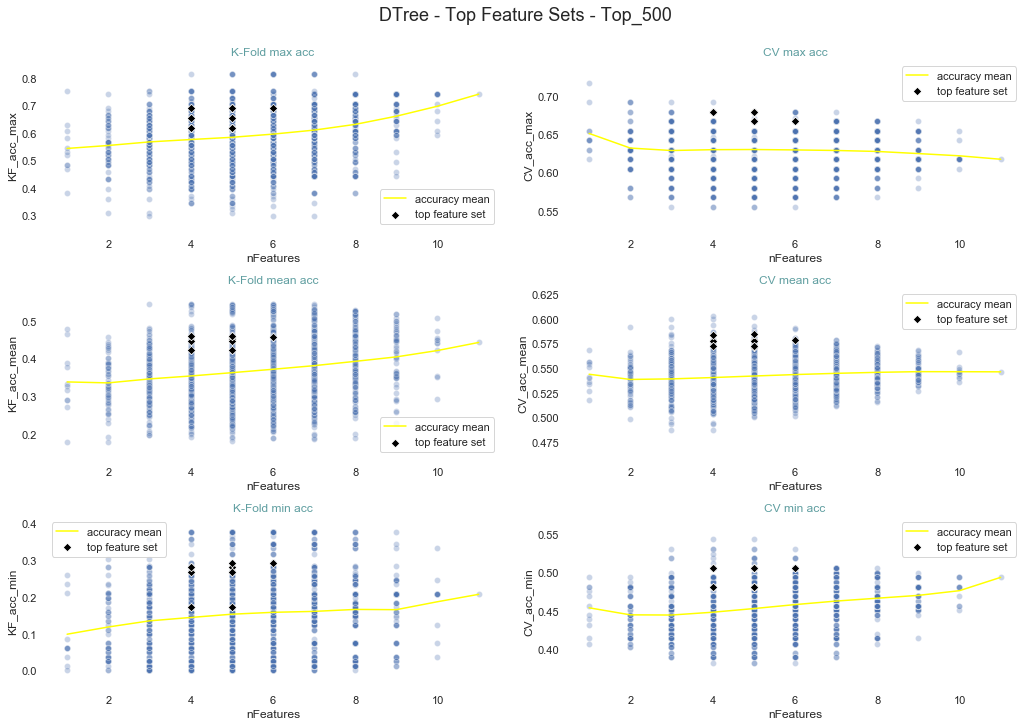

In [1519]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
axis_x = 'nFeatures'
axis_y = ['KF_acc_max', 'CV_acc_max', 'KF_acc_mean', 'CV_acc_mean', 'KF_acc_min', 'CV_acc_min']
titles_figs =['K-Fold max acc', 'CV max acc', 'K-Fold mean acc', 'CV mean acc', 'K-Fold min acc', 'CV min acc']
data = dfc
data_match = DTree_top_feats_500
data_dfs = [KFold_2, CV_2, KFold_2, CV_2, KFold_2, CV_2]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
fig.suptitle('DTree - Top Feature Sets - Top_500', y=1.02, fontsize=18)

for ax_y, titl, data_df, figs in zip(axis_y, titles_figs, data_dfs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.3).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=1, label='potential match', color='red')
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_match, ax=axs[figs], alpha=1, label='match', color='green')
    sns.scatterplot(x=axis_x, y=ax_y, data=data_match, ax=axs[figs], alpha=1, label='top feature set', color='black', marker='D')
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/DTree_Top_Feature_Sets_Top_500.png', bbox_inches='tight', format='png', dpi=500)

In [1520]:
print('Top_500 K-Folds accuracy: {} %'.format(round(100*DTree_top_feats_500.KF_acc_mean.mean(), 2)))
print('Top_500 Cross Validation accuracy: {} %'.format(round(100*DTree_top_feats_500.CV_acc_mean.mean(), 2)))

Top_500 K-Folds accuracy: 44.72 %
Top_500 Cross Validation accuracy: 57.71 %


Top feature set are between 4 and 6 features

In [1521]:
feature_top = {'Hotel':0, 'Tourism':0, 'University':0, 'Cafe':0, 'Pub':0, 
               'Luas':0, 'Museum':0,'Restaurant':0, 'Company':0, 'Liffey':0, 'Price Area':0}
for feat in feature_top.keys():
    for combo in DTree_top10_list_500:
        feature_top[feat] += combo.count(feat)
print(feature_top)

{'Hotel': 9, 'Tourism': 0, 'University': 3, 'Cafe': 2, 'Pub': 0, 'Luas': 0, 'Museum': 9, 'Restaurant': 3, 'Company': 4, 'Liffey': 9, 'Price Area': 4}


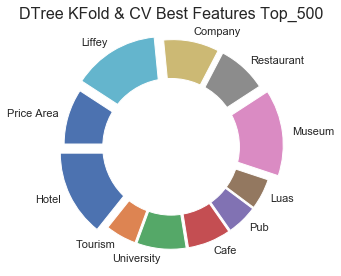

In [1528]:
for feat in feature_top.keys(): # there are several null values.
    feature_top[feat] += 1      # this is just for a better visualization

labels = feature_top.keys()
sizes = feature_top.values()
explode = (0.15,0.05,0.05,0.05, 0.05,0.05,0.15,0.1,0.1,0.15,0.1)
plt.pie(sizes, labels=labels,  startangle=180, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('DTree KFold & CV Best Features Top_500', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/DTree_KFold_CV_Best_Features_Top_500.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code2">DTree KFold train set accuracy</a>

(considering best combinations of feature set)

Top_250

In [1533]:
DTree_CV_top_feats_Top_250.combo

0                                               [Hotel]
2                                       [Hotel, Museum]
3                                      [Hotel, Company]
7                          [Hotel, Tourism, Price Area]
11                         [Hotel, Company, Price Area]
22             [Hotel, University, Company, Price Area]
42    [Hotel, Tourism, University, Company, Price Area]
Name: combo, dtype: object

In [1537]:
n=10
dff = df.loc[df['Ranking'] <= 500].copy()                          
dtree_train = []
for combo in DTree_CV_top_feats_Top_250.combo:
    X = dff[combo].values 
    y = dff['Top_250'].values
    
    clf = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        dtree_train.append(metrics.accuracy_score(y_train, yhat_train))

print('n Feature set: {}'.format(len(DTree_CV_top_feats_Top_250.combo)))
print('Number of results to calculate the average: {} x 10 Folds = {}'.format(len(DTree_CV_top_feats_Top_250.combo), len(dtree_train)))
print('DTree K-Fold Train accuracy mean for best feature sets Top_250: {} %'.format(round(100*np.mean(dtree_train), 2)))

n Feature set: 7
Number of results to calculate the average: 7 x 10 Folds = 70
DTree K-Fold Train accuracy mean for best feature sets Top_250: 64.12 %


Top_500

In [1539]:
DTree_top_feats_500.combo

57                         [Hotel, Cafe, Museum, Liffey]
69                   [Hotel, Museum, Restaurant, Liffey]
70                      [Hotel, Museum, Company, Liffey]
144      [Hotel, University, Museum, Restaurant, Liffey]
145         [Hotel, University, Museum, Company, Liffey]
154            [Hotel, Cafe, Museum, Liffey, Price Area]
166      [Hotel, Museum, Restaurant, Liffey, Price Area]
167         [Hotel, Museum, Company, Liffey, Price Area]
246    [Hotel, University, Museum, Company, Liffey, P...
Name: combo, dtype: object

In [1538]:
n=10
dff = df.loc[df['Ranking'] <= 1500].copy()                          
dtree_train = []
for combo in DTree_top_feats_500.combo:
    X = dff[combo].values 
    y = dff['Top_500'].values
    
    clf = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        dtree_train.append(metrics.accuracy_score(y_train, yhat_train))

print('n Feature set: {}'.format(len(DTree_top_feats_500.combo)))
print('Number of results to calculate the average: {} x 10 Folds = {}'.format(len(DTree_top_feats_500.combo), len(dtree_train)))
print('DTree K-Fold Train accuracy mean for best feature sets Top_500: {} %'.format(round(100*np.mean(dtree_train), 2)))

n Feature set: 9
Number of results to calculate the average: 9 x 10 Folds = 90
DTree K-Fold Train accuracy mean for best feature sets Top_500: 65.3 %


### <a id="code3">ROC Curve</a>

ROC displays a curve with a point for each of the True Positive Rate and False Positive Rate of the model at distant threshold levels, letting us see the compensation between the FPR and TPR for all threshold levels.

In [3]:
dtree_total_top_250 = pd.read_csv('CSVs/dtree_total_top_250.csv')
dtree_total_top_500 = pd.read_csv('CSVs/dtree_total_top_500.csv')

Top_250

In [4]:
dtree_total_top_250.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,accuracy_train,max_depth,f1_score,jaccard_score,random_state,nFeatures
147564,"['Cafe', 'Pub', 'Price Area']",0.722892,0.650456,8,0.711495,0.555895,12,3
128749,"['Hotel', 'Tourism', 'University', 'Cafe', 'Lu...",0.722892,0.702128,6,0.722892,0.566038,84,8


In [10]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit
X = np.asarray(dff[['Cafe', 'Pub', 'Price Area']])
y = np.asarray(dff['Top_250']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=dff['Top_250']) #Top_250/Top_500
clf = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.7228915662650602
f1: 0.7114948751594344
jaccard: 0.5558951347913649


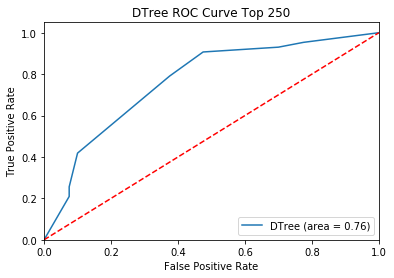

In [13]:
dtree_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DTree (area = %0.2f)' % dtree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DTree ROC Curve Top 250')
plt.legend(loc="lower right")
plt.savefig('charts/DTree_ROC_Curve_Top_250.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

Top_500

In [14]:
dtree_total_top_500.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,accuracy_train,max_depth,f1_score,jaccard_score,random_state,nFeatures
156185,"['Hotel', 'Tourism', 'Pub', 'Luas', 'Liffey']",0.699387,0.766975,8,0.699341,0.537732,24,5
27746,"['Hotel', 'Tourism', 'Luas', 'Museum', 'Restau...",0.693252,0.649691,4,0.686749,0.524987,39,6


In [16]:
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500 to keep y.var() close to unit
X = np.asarray(dff[['Hotel', 'Tourism', 'Pub', 'Luas', 'Liffey']])
y = np.asarray(dff['Top_500']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=dff['Top_500']) #Top_250/Top_500
clf = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.6993865030674846
f1: 0.6994091353653904
jaccard: 0.5377749746765285


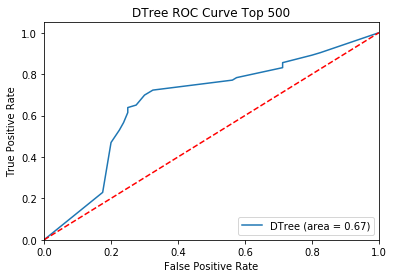

In [17]:
dtree_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DTree (area = %0.2f)' % dtree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DTree ROC Curve Top 500')
plt.legend(loc="lower right")
plt.savefig('charts/DTree_ROC_Curve_Top_500.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code4">Validation</a>

As we left 40 samples out of the scope to train the classifiers, let's see how they perform.<br>
Notice that all samples are negative, this means that in order to get 100% accuracy the classifier should predict 40 negatives and zero positives.

In [4]:
dtree_total_top_250 = pd.read_csv('CSVs/dtree_total_top_250.csv')
DTree_KF_CV_250 = pd.read_csv('CSVs/DTree_KF_CV_250.csv')
dtree_total_top_500 = pd.read_csv('CSVs/dtree_total_top_500.csv')
DTree_KF_CV_500 = pd.read_csv('CSVs/DTree_KF_CV_500.csv')

Top_250

In [7]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit
df_val = df.loc[df['Ranking'] > 1500] # 40 samples for validation.
val = pd.DataFrame()
results = [dtree_total_top_250, DTree_KF_CV_250, DTree_KF_CV_250] #Top_250/Top_500
methods = ['random_state', 'KFold', 'cross_val_score']
acc_max = ['accuracy', 'KF_acc_max', 'CV_acc_max' ]

for acc, method, result in zip(acc_max, methods, results):
    feat_set = literal_eval(result.sort_values(by=[acc], ascending=False).head(1)['combo'].values[0])
    X_train = np.asarray(dff[feat_set])
    y_train = np.asarray(dff['Top_250']) #Top_250/Top_500
    X_val = np.asarray(df_val[feat_set])
    y_val = np.asarray(df_val['Top_250']) #Top_250/Top_500

    clf = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
    clf.fit(X_train, y_train)

    yhat = clf.predict(X_val)
    val_temp = pd.DataFrame([confusion_matrix(y_val, yhat)[0,:]], 
             columns=['Predicted Negative', 'Predicted Positive'], index=[method])
    val = val.append(val_temp)
val.index.name = 'Method' 
val['Accuracy %'] = round(100*(val['Predicted Negative']/
                                 (val['Predicted Negative']+val['Predicted Positive'])), 2)
DTree_val_Top_250 = val.copy()  #Top_250/Top_500
DTree_val_Top_250.to_csv('CSVs/DTree_val_Top_250.csv')
DTree_val_Top_250

,Predicted Negative,Predicted Positive,Accuracy %
Method,,,
random_state,9,31,22.5
KFold,7,33,17.5
cross_val_score,27,13,67.5


Top_500

In [14]:
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500 to keep y.var() close to unit
df_val = df.loc[df['Ranking'] > 1500] # 40 samples for validation.
val = pd.DataFrame()
results = [dtree_total_top_500, DTree_KF_CV_500, DTree_KF_CV_500] #Top_250/Top_500
methods = ['random_state', 'KFold', 'cross_val_score']
acc_max = ['accuracy', 'KF_acc_max', 'CV_acc_max' ]

for acc, method, result in zip(acc_max, methods, results):
    feat_set = literal_eval(result.sort_values(by=[acc], ascending=False).head(1)['combo'].values[0])
    X_train = np.asarray(dff[feat_set])
    y_train = np.asarray(dff['Top_500']) #Top_250/Top_500
    X_val = np.asarray(df_val[feat_set])
    y_val = np.asarray(df_val['Top_500']) #Top_250/Top_500

    clf = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    clf.fit(X_train, y_train)

    yhat = clf.predict(X_val)
    val_temp = pd.DataFrame([confusion_matrix(y_val, yhat)[0,:]], 
             columns=['Predicted Negative', 'Predicted Positive'], index=[method])
    val = val.append(val_temp)
val.index.name = 'Method' 
val['Accuracy %'] = round(100*(val['Predicted Negative']/
                                 (val['Predicted Negative']+val['Predicted Positive'])), 2)
DTree_val_Top_500 = val.copy()  #Top_250/Top_500
DTree_val_Top_500.to_csv('CSVs/DTree_val_Top_500.csv')
DTree_val_Top_500

,Predicted Negative,Predicted Positive,Accuracy %
Method,,,
random_state,24,16,60.0
KFold,29,11,72.5
cross_val_score,21,19,52.5


### Diamond shape of charts versus nFeatures.

At higher number of combinations (5 & 6 nFeatures) there is more probability to find extreme max and min (farest from the mean accuracy) running the classifier

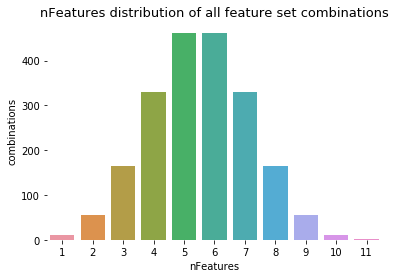

In [1363]:
nFeatures_combo = {}
for i in range(1,12):
    nFeatures_combo[i]=0
for combo in feat_combo:
    nFeatures_combo[len(combo)] +=1   
plt.title('nFeatures distribution of all feature set combinations', fontsize=13)
sns.barplot(x=list(nFeatures_combo.keys()), y=list(nFeatures_combo.values()))
plt.xlabel('nFeatures')
plt.ylabel('combinations')
plt.savefig('charts/nFeatures_dist_feat_combo.png', bbox_inches='tight', format='png', dpi=500)

## <center> [Table of Contents](./0.Table_of_Contents_Code.ipynb) </center>